# Objetivo


*   Entender e avaliar qualidade dos dados
*   Avaliar distribuição da coluna "categoria"
*   Definir e explicar decisões para a modelagem

---

Decidir utilizar o notebook para explicar melhor o EDA e a logica para toda construção. Assim como facilitar a apresentação, todo o projeto está disponivel em https://github.com/dsantip3labs/et-cientista-dados-aec, com o README e documentação para utilização.

---

Para o notebook não ficar extenso, vou separar em secção com mais código e avaliando os dados e quando achar necessario realizar os comentarios antes ou em seguida da execução.


# Configuração

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 120)

# Qualidade dos dados


Vou iniciar carregando o arquivo e em seguida realizar as analises de qualidade. (Strings vazias, dados nulos, duplicados e etc)

In [34]:
caminho = 'sample_data/articles.csv'

dados = pd.read_csv(caminho, encoding='utf-8', sep=',')

# Conferindo os dados, as colunas, tipos de dados, quantidade de linhas e os dtypes.
print(dados.info())

# Nulos

nulos = dados.isna().sum()
print(nulos)

print(dados.isna().mean().sort_values(ascending=False))


# Vou utilizar titulo e o texto para avaliar a categoria

def linhas_vazias(col):
    s = col.fillna("").astype(str).str.strip()
    return (s == "").mean()

for c in ["title", "text"]:
    if c in dados.columns:
        print(c, linhas_vazias(dados[c]))

# Duplicados

dados.duplicated().mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167053 entries, 0 to 167052
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        167053 non-null  object
 1   text         166288 non-null  object
 2   date         167053 non-null  object
 3   category     167053 non-null  object
 4   subcategory  29635 non-null   object
 5   link         167053 non-null  object
dtypes: object(6)
memory usage: 7.6+ MB
None
title               0
text              765
date                0
category            0
subcategory    137418
link                0
dtype: int64
subcategory    0.822601
text           0.004579
title          0.000000
date           0.000000
category       0.000000
link           0.000000
dtype: float64
title 0.0
text 0.004579384985603371


np.float64(0.0)

Com base no resultado, temos:

*   Uma base com 6 colunas e 167.053 linhas;
*   Todos em formato de string;
*   Subcategoria e texto possuem linhas vazias ou nulas, sendo 82% e 0,004% respectivamente;
*   Nenhum dado duplicado.

Apesar de exister linhas sem texto, não irei remover da base. Pois vou utilizar titulo ou texto como input.



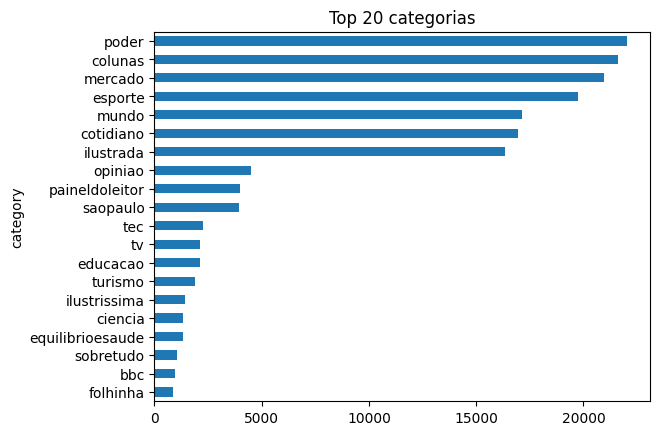

---
Desbalanceamento: 22022.0


In [17]:
coluna = "category"
top_n = 20

contagem = dados[coluna].value_counts()

contagem.head(top_n).sort_values().plot(kind="barh")
plt.title(f"Top {top_n} categorias")
plt.show()

print("---")

ratio = contagem.max() / contagem.min()
print(f"Balanceamento: {ratio}")

Aqui comecei trouxe em grafico as categorias em seu top 20 e avaliei o desbalanceamento entre eles para definir qual modelo utilizar. Achei 22 mil muito alto, então para ter um certeza confirmei a quantidade das menores categorias.

In [19]:
counts = dados["category"].value_counts()
counts.tail(20)

,count
category,
guia-de-livros-discos-filmes,143
topofmind,86
banco-de-dados,64
dw,48
infograficos,43
cenarios-2017,43
especial,43
rfi,29
guia-de-livros-filmes-discos,28


OK. Sobre isso tenho, algumas categorias com 1 valor, o que explica o ratio de 22 mil. Além disso, essas categorias como 20116,2015 me parecem mais uma tag do que categoria.

Sinceramente, essas categorias com valores baixos não servem para ensinar o modelo um padrão, vou avaliar a remoção para que o modelo não alucine e ensinar somente as categorias com um valor minimo.

# Filtros

Vou manter mesmo apenas categorias com pelo menos 20 exemplos, para tornar o treino e as avaliações mais estaveis.

In [22]:
MIN_COUNT = 20

total = dados[coluna].value_counts()
categorias_validas = total[total >= MIN_COUNT].index

dados_final = dados[dados[coluna].isin(categorias_validas)].copy()

categorias_removidas = total[total < MIN_COUNT]
linhas_removidas = categorias_removidas.sum()

print("Categorias originais:", total.shape[0])
print("Categorias mantidas:", len(categorias_validas))
print("Categorias removidas:", categorias_removidas.shape[0])
print("Linhas removidas:", int(linhas_removidas))
print("Linhas mantidas:", dados_final.shape[0])

Categorias originais: 48
Categorias mantidas: 39
Categorias removidas: 9
Linhas removidas: 51
Linhas mantidas: 167002


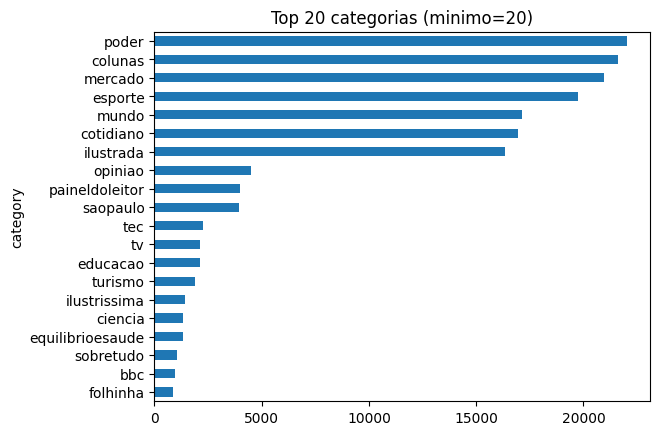


---

Novo desbalanceamento: 1048.6666666666667
Min: 21 | Max: 22022


In [27]:
counts = dados_final[coluna].value_counts()

top_n = 20
counts.head(top_n).sort_values().plot(kind="barh")
plt.title(f"Top {top_n} categorias (minimo={MIN_COUNT})")
plt.show()

ratio = counts.max() / counts.min()

print("\n---\n")

print("Novo desbalanceamento:", float(ratio))
print("Min:", int(counts.min()), "| Max:", int(counts.max()))

# Texto, modelo e treino

Com isso definido, vamos iniciar a modelagem de dados para definir esse arquivo como treinável e o que iremos levar para produção.

Iniciando com a limpeza e unificação do title e text para servir como input. Junto de uma verificação para encontrar possiveis textos vazios.

Basicamente:
Se text existir e não estiver vazio > usa text
Senão > usa title

In [28]:
def norm_str(x):
    if pd.isna(x):
        return ""
    return str(x).strip()

dados_final["title_clean"] = dados_final["title"].map(norm_str) if "title" in dados_final.columns else ""
dados_final["text_clean"]  = dados_final["text"].map(norm_str)  if "text" in dados_final.columns else ""

dados_final["input_text"] = np.where(dados_final["text_clean"].str.len() > 0, dados_final["text_clean"], dados_final["title_clean"])

empty_input_rate = (dados_final["input_text"].str.len() == 0).mean()
print("Taxa de input_text vazio:", empty_input_rate)

Taxa de input_text vazio: 0.0


Aqui avalio a distribuição do tamanho do texto, identifico outliers e verificar se vai precisar de pré-processmento. Também validar possiveis ruídos.


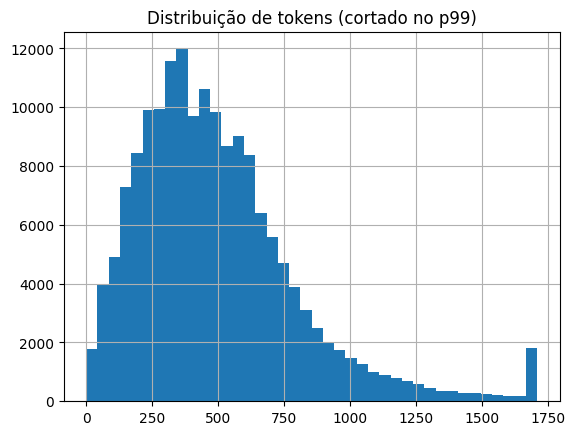

In [30]:
dados_final["token_len"].clip(upper=dados_final["token_len"].quantile(0.99)).hist(bins=40)
plt.title("Distribuição de tokens (cortado no p99)")
plt.show()

In [ ]:
dados_final.sort_values("token_len", ascending=False)[["input_text", coluna, "token_len"]].head(5)
dados_final.sort_values("token_len", ascending=True)[["input_text", coluna, "token_len"]].head(5)

Aplico uma limpeza no texto, focada em remover ruídos óbvios sem acabar com o conteúdo

In [ ]:
def clean_text(s):
    s = str(s).lower().strip()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

dados_final["input_text_clean"] = dados_final["input_text"].map(clean_text)
dados_final[["input_text", "input_text_clean"]].head(3)

Para avaliar de forma justa separo os dados em treino e teste mantendo a proporção de classes.

In [33]:
from sklearn.model_selection import train_test_split

X = dados_final["input_text_clean"]
y = dados_final[coluna]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Treino:", X_train.shape[0], "Teste:", X_test.shape[0])
print("Min count treino:", int(y_train.value_counts().min()))
print("Min count teste:", int(y_test.value_counts().min()))

Treino: 133601 Teste: 33401
Min count treino: 17
Min count teste: 4


# Decisões finais



* Filtro de classes: mantive apenas categorias com pelo menos 20 exemplos para garantir estabilidade de treino e avaliação.  
* Texto usado: input_text com fallback text > title.  
* Pré-processamento: limpeza mínima (lowercase, remoção de URLs, normalização de espaços).
* Métrica principal: F1 macro